In [36]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium
from IPython.display import display, HTML
import os
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [37]:
df=pd.read_excel('https://raw.githubusercontent.com/BiancaDiFranco/M-todosOP/main/Trabajo%20final/Rosario%20F.xlsx', engine='openpyxl')
secciones=gpd.read_file('https://github.com/BiancaDiFranco/M-todosOP/raw/refs/heads/main/Trabajo%20final/datasets%20complementarios/secciones_catastrales.gml')
distritos=gpd.read_file('https://github.com/BiancaDiFranco/M-todosOP/raw/refs/heads/main/Trabajo%20final/datasets%20complementarios/distritos_descentralizados.gml')
barrios=gpd.read_file('https://github.com/BiancaDiFranco/M-todosOP/raw/refs/heads/main/Trabajo%20final/datasets%20complementarios/barrios.gml')

In [38]:
geometry = [Point(xy) for xy in zip(df['Coord1__Longitude'], df['Coord1__Latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)
gdf.set_crs('EPSG:4326', inplace=True)
union=gpd.sjoin(gdf, barrios, how='inner', predicate='within')
unionseccion=gpd.sjoin(gdf, secciones, how='inner', predicate='within')
uniondistritos=gpd.sjoin(gdf, distritos, how='inner', predicate='within')

In [39]:
colores_partidos = {
    'LIBERTARIOS': '#BF00BF',
    'FdT': '#00BFBF',
    'OTROS': '#ADFF2F',
    'NINGUNO/NOSABE': '#696969',
    'JxC': '#F2CB07',
    'PNK': '#483D8B',
    'FIT': '#8B0000',
}

In [40]:
gdf['color']=gdf['INT DE VOTO X ESPACIO'].map(colores_partidos).fillna('black')

In [41]:
#Filtrado de datos para Rosario
lat_min_valid = -33.0
lat_max_valid = -32.85
lon_min_valid = -60.790
lon_max_valid = -60.6
gdf = gdf[
    (gdf['Coord1__Latitude'] >= lat_min_valid) &
    (gdf['Coord1__Latitude'] <= lat_max_valid) &
    (gdf['Coord1__Longitude'] >= lon_min_valid) &
    (gdf['Coord1__Longitude'] <= lon_max_valid)
]

In [42]:
m = folium.Map(location=[-32.9, -60.7], zoom_start=13)
for _, row in gdf.iterrows():
    folium.Marker(
        location=[row['Coord1__Latitude'], row['Coord1__Longitude']],
        popup=(
            f"EDAD: {row['EDAD']}<br>"
            f"GENERO: {row['GENERO']}<br>"
            f"INT DE VOTO: {row['INT DE VOTO X ESPACIO']}<br>"
            f"RADIO: {row['RADIO']}"
        )
    ).add_to(m)

map_path = "Rosario_Mapa.html"
m.save(map_path)
map_html = m._repr_html_()
display(HTML(map_html))

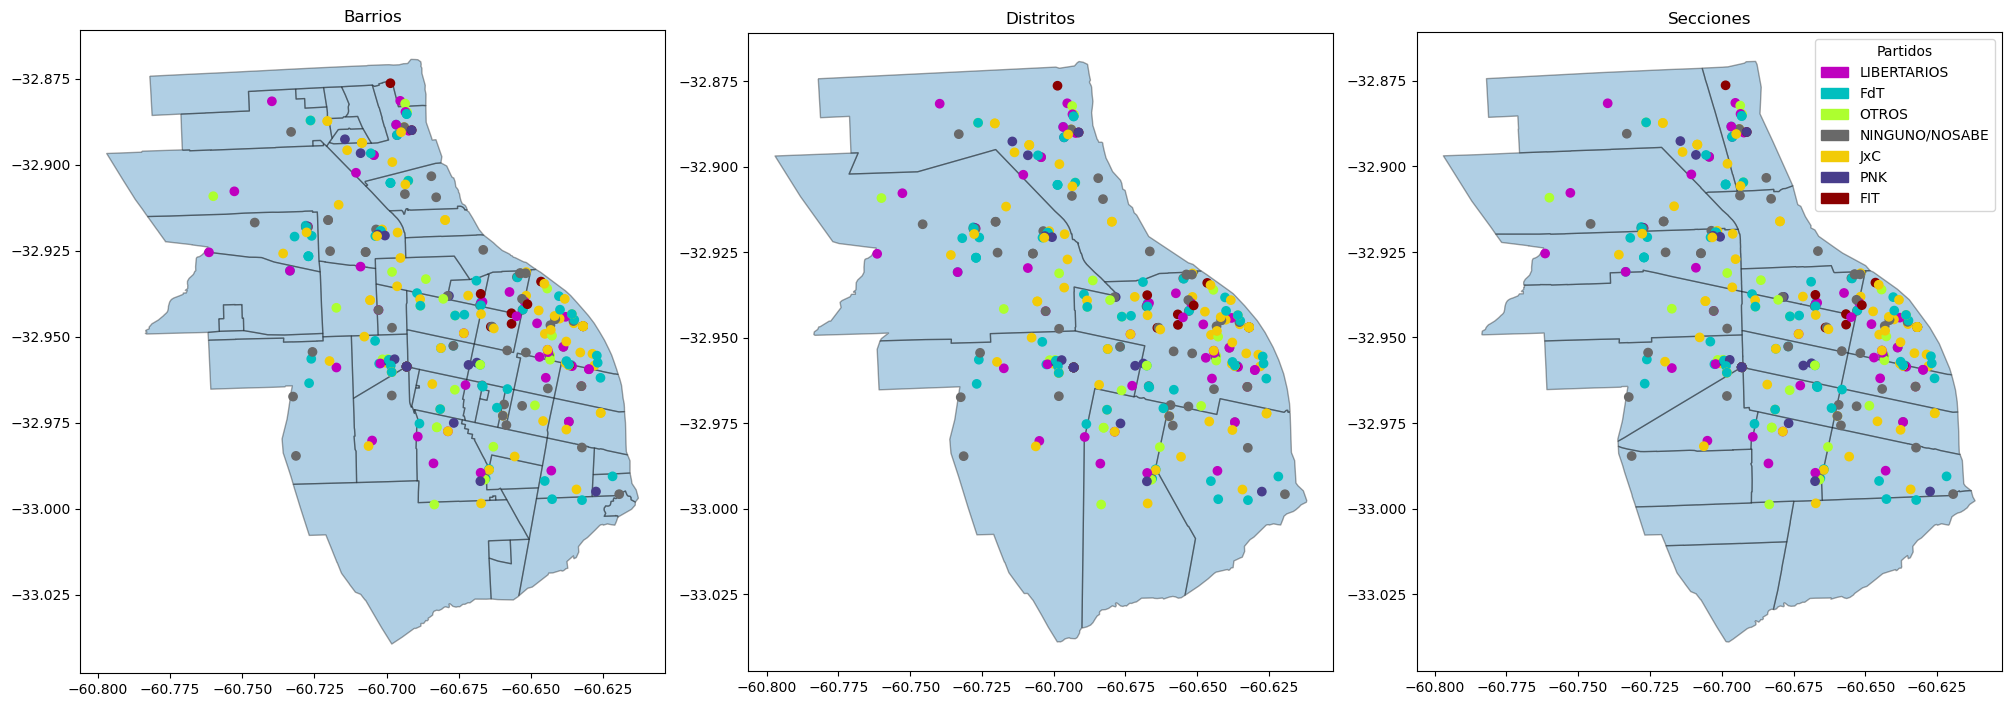

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10), constrained_layout=True)
base = barrios.plot(figsize=(20, 20), alpha=0.35, edgecolor='k', ax=axes[0])
gdf.plot(ax=base, color=gdf['color'])
axes[0].set_title('Barrios')
base = distritos.plot(figsize=(20, 20), alpha=0.35, edgecolor='k', ax=axes[1])
gdf.plot(ax=base, color=gdf['color'])
axes[1].set_title('Distritos')
base = secciones.plot(figsize=(20, 20), alpha=0.35, edgecolor='k', ax=axes[2])
gdf.plot(ax=base, legend=True, color=gdf['color'])
axes[2].set_title('Secciones')
leyenda = [mpatches.Patch(color=color, label=partido) for partido, color in colores_partidos.items()]

plt.legend(handles=leyenda, title='Partidos', loc='upper right', fontsize=10)
plt.show()


In [44]:
conteo_votos = (
    union.groupby(['BARRIO', 'INT DE VOTO X ESPACIO'])
    .size()
    .reset_index(name='conteo')
)
mayor_votos_por_barrio = conteo_votos.loc[conteo_votos.groupby('BARRIO')['conteo'].idxmax()]
barrios = barrios.merge(mayor_votos_por_barrio, on='BARRIO', how='left')
barrios['color'] = barrios['INT DE VOTO X ESPACIO'].map(colores_partidos).fillna('black')
conteo_votos_por_barrio = (
    union.groupby('BARRIO')
    .size()
    .reset_index(name='cantidad_votos')
)
barrios = barrios.merge(conteo_votos_por_barrio, on='BARRIO', how='left')

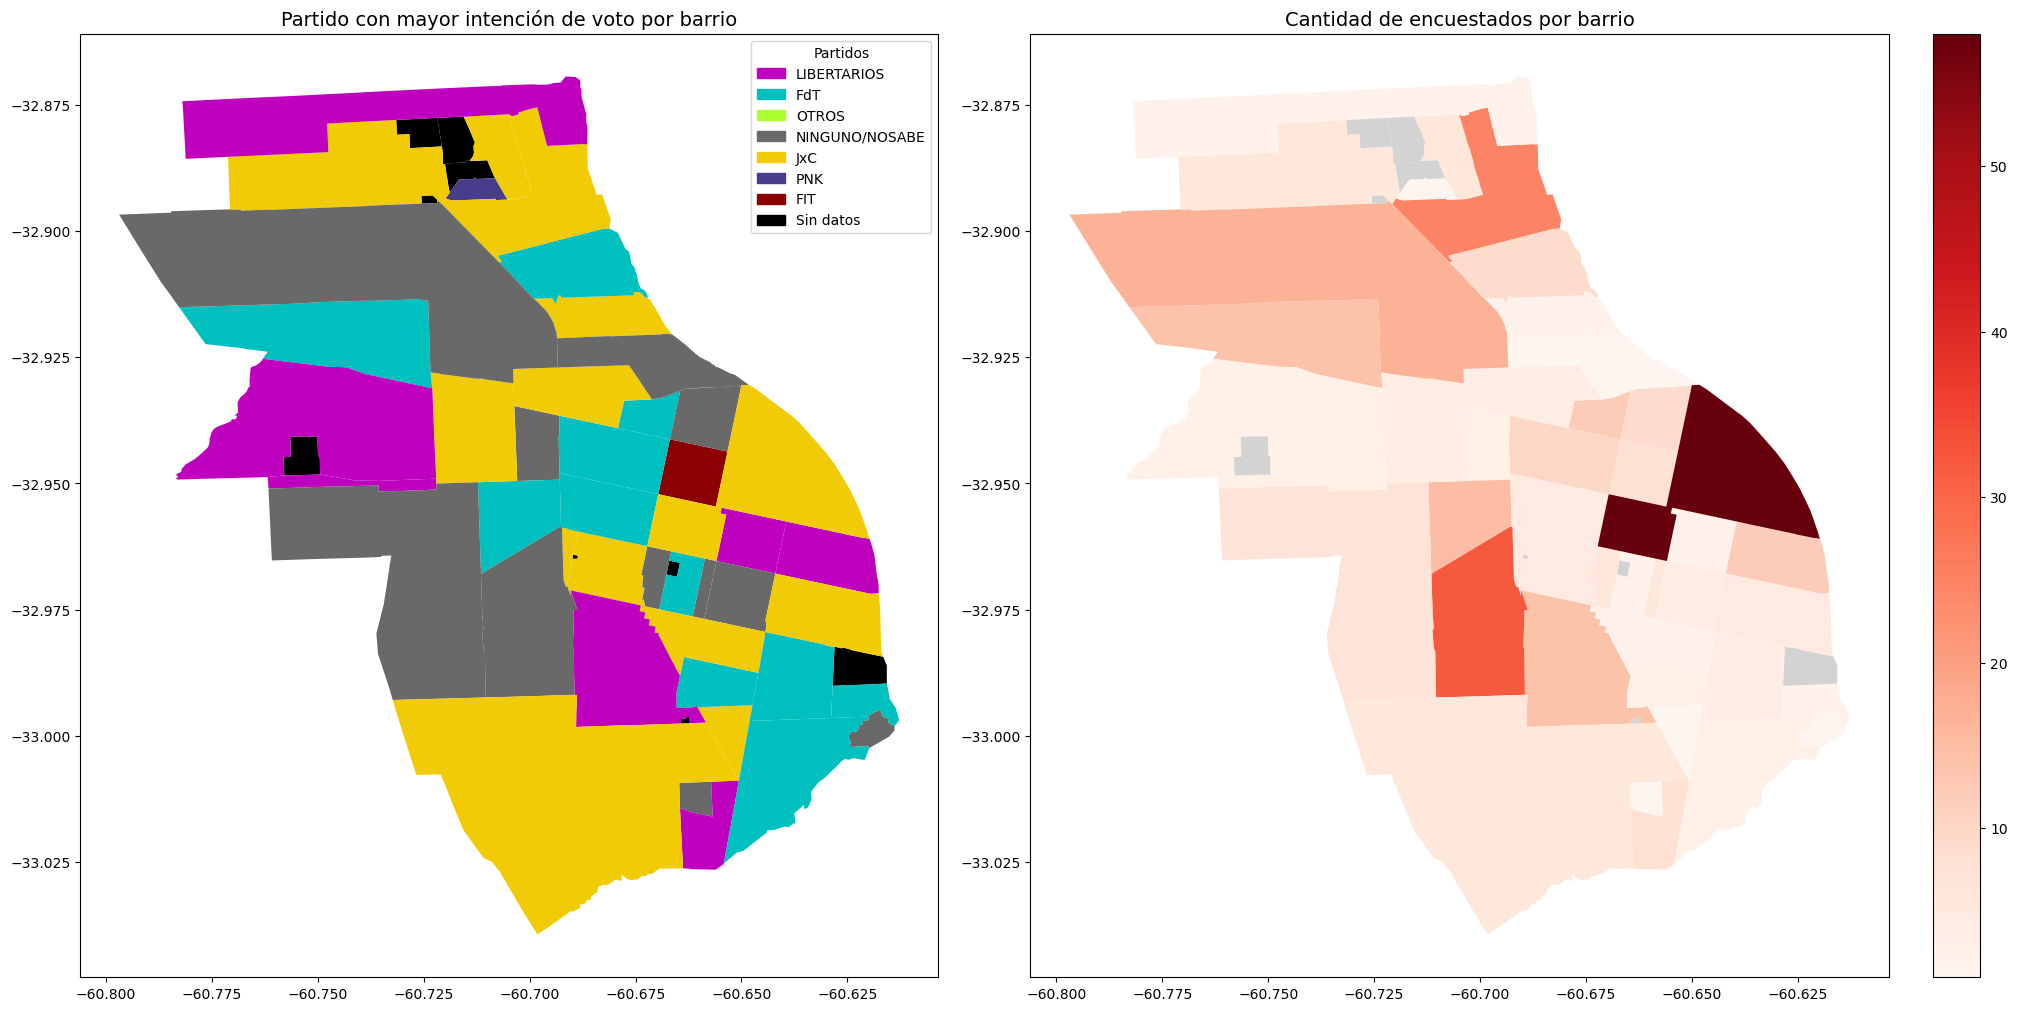

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10), constrained_layout=True)
barrios.plot(color=barrios['color'], ax=axes[0])
axes[0].set_title('Partido con mayor intención de voto por barrio', fontsize=14)
leyenda = [mpatches.Patch(color=color, label=partido) for partido, color in colores_partidos.items()]
leyenda.append(mpatches.Patch(color='black', label='Sin datos'))
axes[0].legend(handles=leyenda, title='Partidos', loc='upper right', fontsize=10)
barrios.plot(
    column='cantidad_votos', 
    cmap='Reds', 
    legend=True, 
    ax=axes[1],
    missing_kwds={
        "color": "lightgrey",
    }
)
axes[1].set_title('Cantidad de encuestados por barrio', fontsize=14)
plt.show()

In [46]:
conteo_votos = (
    uniondistritos.groupby(['DISTRITO', 'INT DE VOTO X ESPACIO'])
    .size()
    .reset_index(name='conteo')
)
mayor_votos_por_distrito = conteo_votos.loc[conteo_votos.groupby('DISTRITO')['conteo'].idxmax()]
distritos = distritos.merge(mayor_votos_por_distrito, on='DISTRITO', how='left')
distritos['color'] = distritos['INT DE VOTO X ESPACIO'].map(colores_partidos).fillna('black')
conteo_votos_por_distrito = (
    uniondistritos.groupby('DISTRITO')
    .size()
    .reset_index(name='cantidad_votos')
)
distritos = distritos.merge(conteo_votos_por_distrito, on='DISTRITO', how='left')

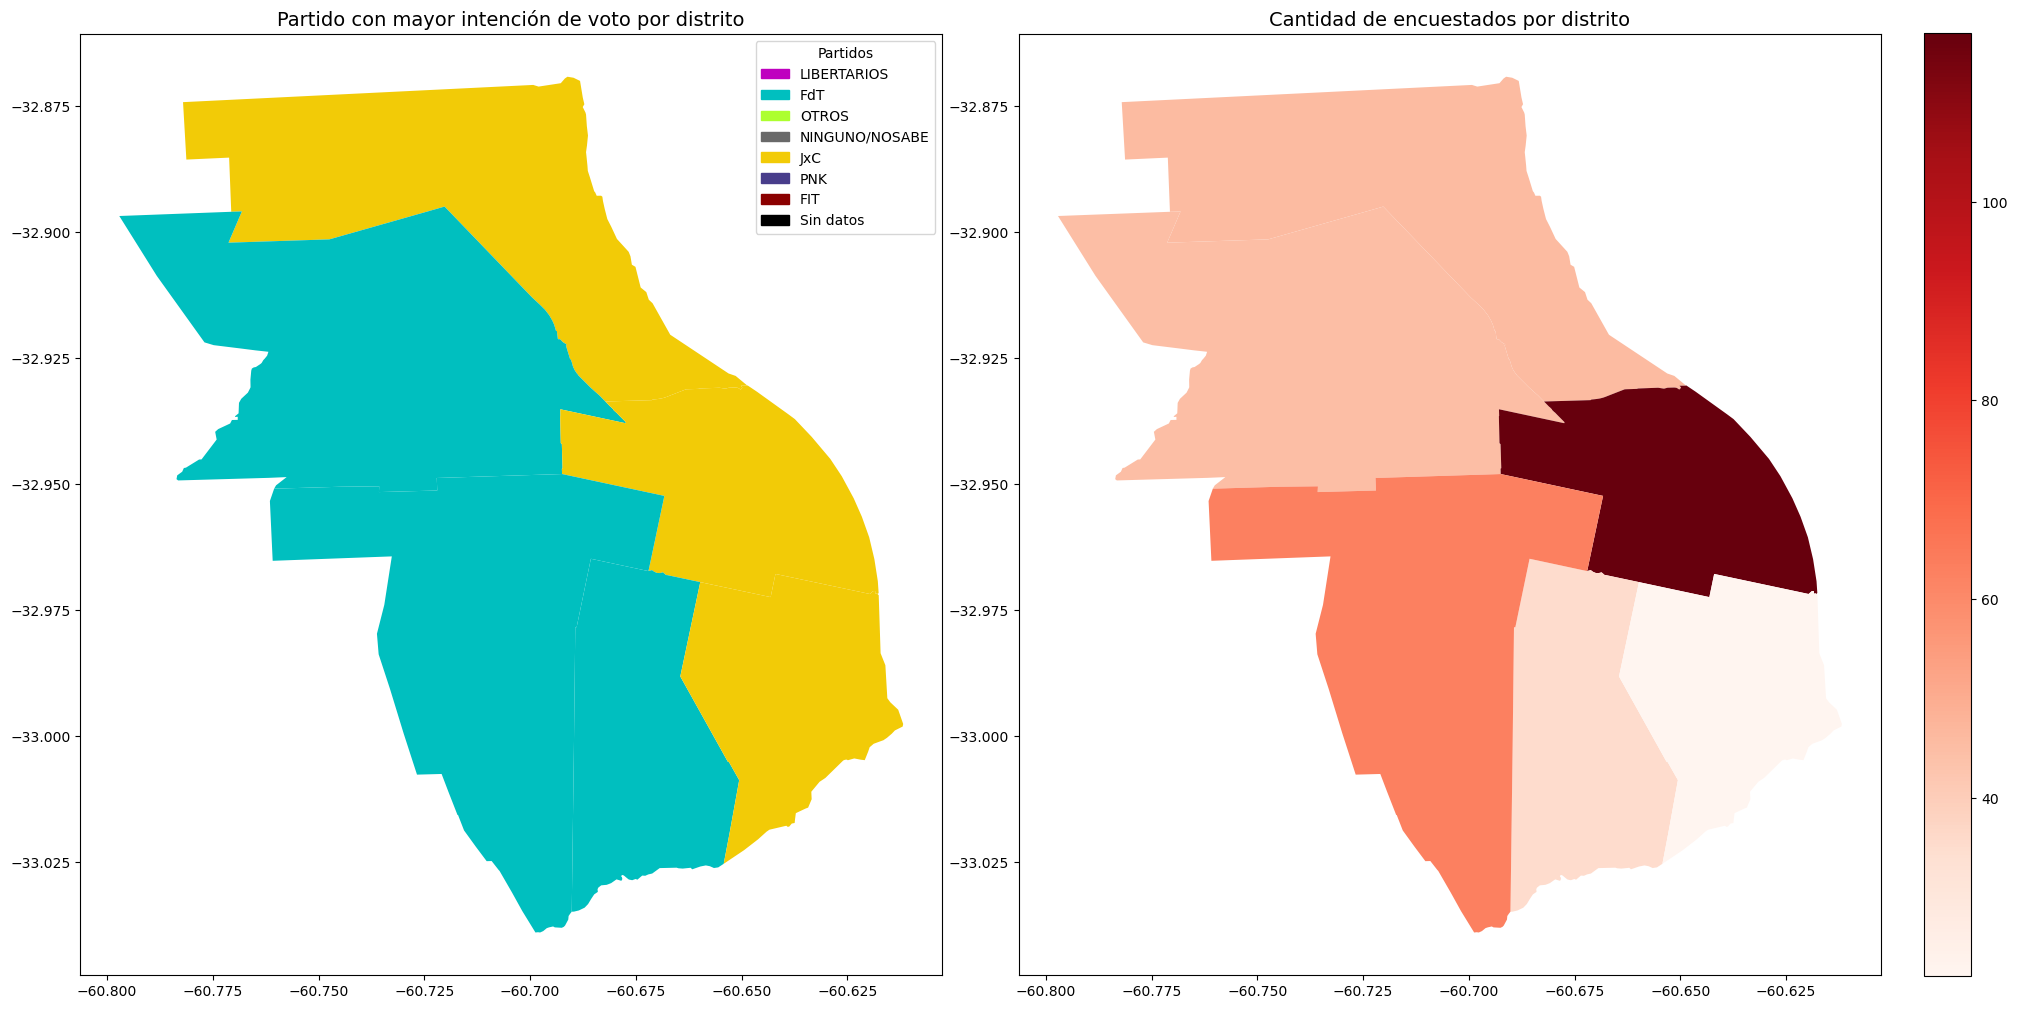

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10), constrained_layout=True)
distritos.plot(color=distritos['color'], ax=axes[0])
axes[0].set_title('Partido con mayor intención de voto por distrito', fontsize=14)
leyenda = [mpatches.Patch(color=color, label=partido) for partido, color in colores_partidos.items()]
leyenda.append(mpatches.Patch(color='black', label='Sin datos'))
axes[0].legend(handles=leyenda, title='Partidos', loc='upper right', fontsize=10)
distritos.plot(
    column='cantidad_votos', 
    cmap='Reds', 
    legend=True, 
    ax=axes[1],
    missing_kwds={
        "color": "lightgrey",
        "label": "Sin datos"}
)
axes[1].set_title('Cantidad de encuestados por distrito', fontsize=14)
plt.show()

In [48]:
conteo_votos = (
    unionseccion.groupby(['SECCION', 'INT DE VOTO X ESPACIO'])
    .size()
    .reset_index(name='conteo')
)
mayor_votos_por_seccion = conteo_votos.loc[conteo_votos.groupby('SECCION')['conteo'].idxmax()]
secciones = secciones.merge(mayor_votos_por_seccion, on='SECCION', how='left')
secciones['color'] = secciones['INT DE VOTO X ESPACIO'].map(colores_partidos).fillna('black')
conteo_votos_por_secciones = (
    unionseccion.groupby('SECCION')
    .size()
    .reset_index(name='cantidad_votos')
)
secciones = secciones.merge(conteo_votos_por_secciones, on='SECCION', how='left')

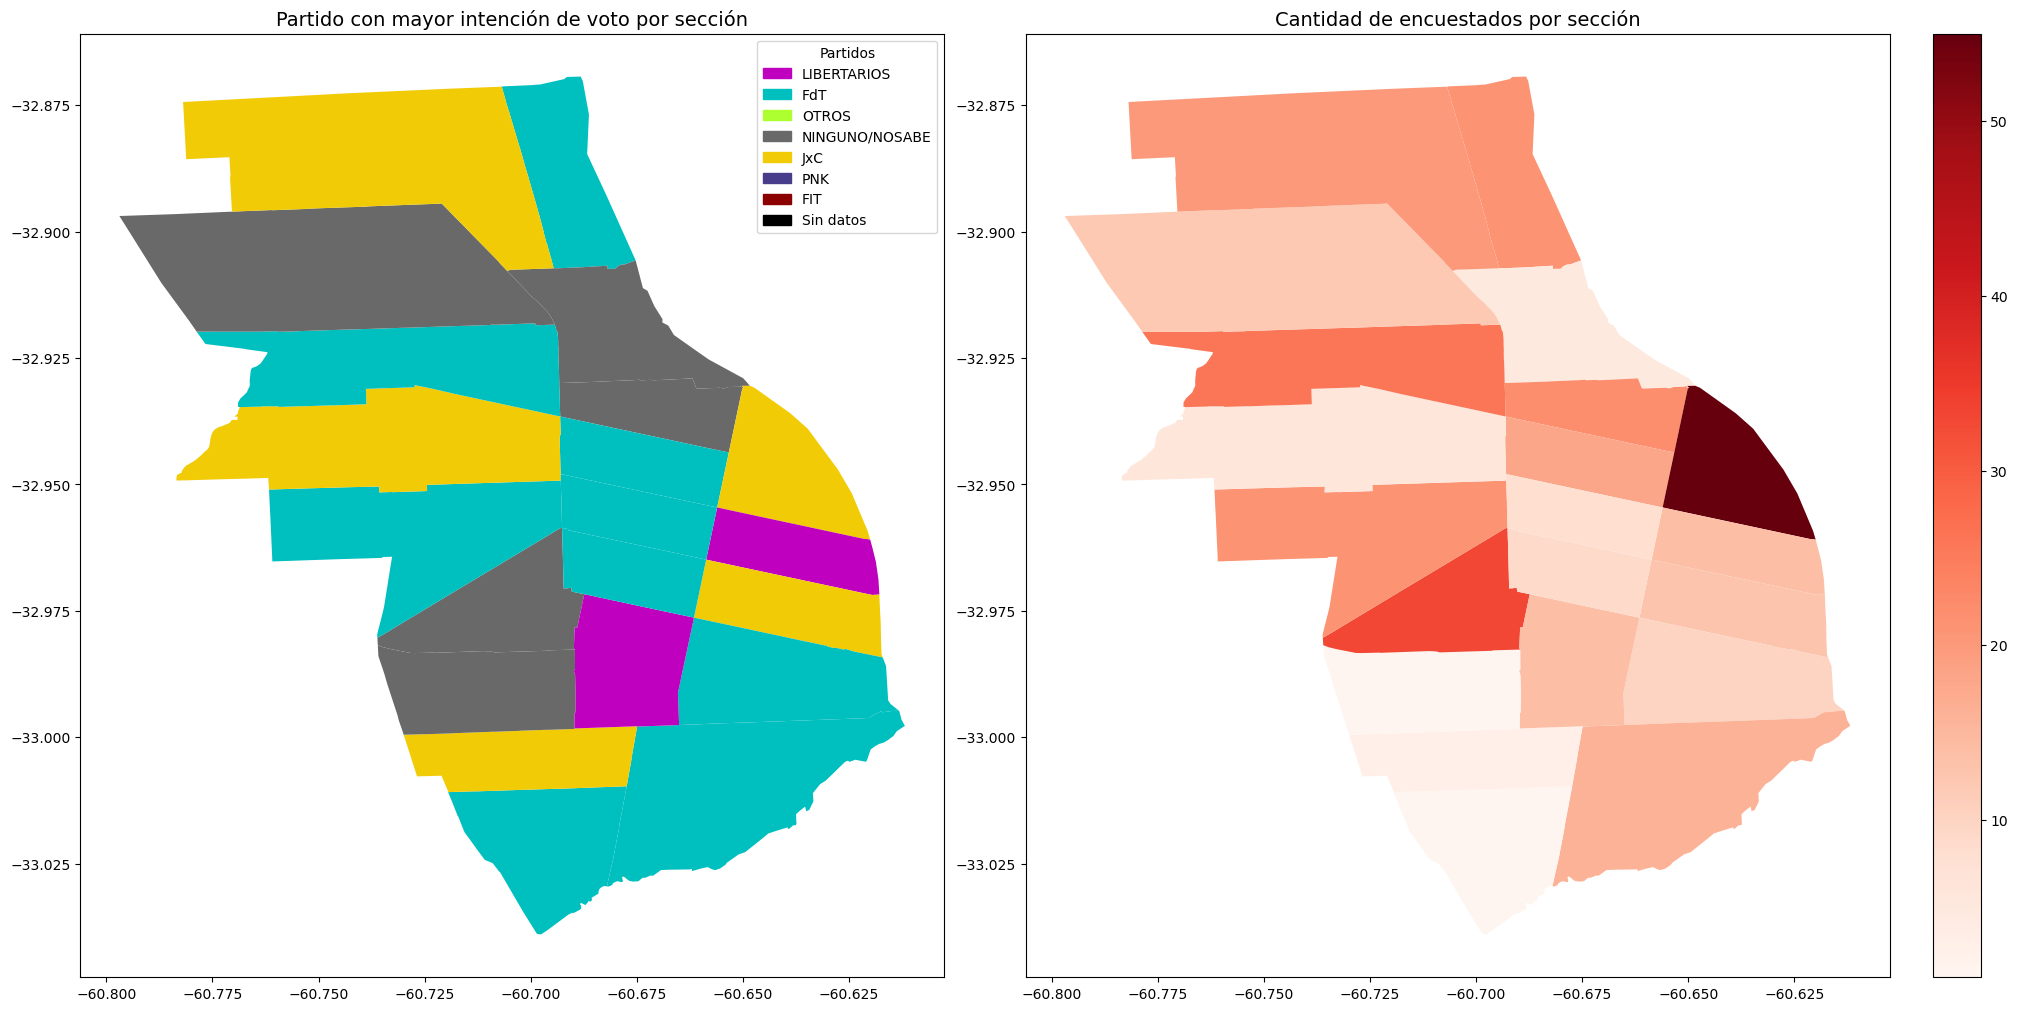

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10), constrained_layout=True)
secciones.plot(color=secciones['color'], ax=axes[0])
axes[0].set_title('Partido con mayor intención de voto por sección', fontsize=14)
leyenda = [mpatches.Patch(color=color, label=partido) for partido, color in colores_partidos.items()]
leyenda.append(mpatches.Patch(color='black', label='Sin datos'))
axes[0].legend(handles=leyenda, title='Partidos', loc='upper right', fontsize=10)
secciones.plot(
    column='cantidad_votos', 
    cmap='Reds', 
    legend=True, 
    ax=axes[1],
    missing_kwds={
        "color": "lightgrey",
        "label": "Sin datos"}
)
axes[1].set_title('Cantidad de encuestados por sección', fontsize=14)
plt.show()

Ahora se va a analizar partido por partido, comenzando por el Frente de Todos

In [50]:
gdf_votos_fdt=union[union['INT DE VOTO X ESPACIO']=='FdT']
conteo_votos_fdt = gdf_votos_fdt.groupby('BARRIO').size().reset_index(name='cantidad_votos_fdt')
barrios = barrios.merge(conteo_votos_fdt, on='BARRIO', how='left')

In [51]:
gdf_votos_fdt_dis=uniondistritos[uniondistritos['INT DE VOTO X ESPACIO']=='FdT']
conteo_votos_fdt_dis = gdf_votos_fdt_dis.groupby('DISTRITO').size().reset_index(name='cantidad_votos_fdt')
distritos = distritos.merge(conteo_votos_fdt_dis, on='DISTRITO', how='left')

In [52]:
gdf_votos_fdt_sec=unionseccion[unionseccion['INT DE VOTO X ESPACIO']=='FdT']
conteo_votos_fdt_sec = gdf_votos_fdt_sec.groupby('SECCION').size().reset_index(name='cantidad_votos_fdt')
secciones = secciones.merge(conteo_votos_fdt_dis, on='SECCION', how='left')

KeyError: 'SECCION'

In [ ]:
unionseccion

In [ ]:
fig, ax = plt.subplots(figsize=(14, 12))
barrios.plot(column='cantidad_votos_fdt', ax=ax, legend=True, cmap='Blues', legend_kwds={'label': f"Votos del FdT por Barrio"})
plt.title(f'Votos del FdT por barrio en Rosario', fontsize=16)
plt.show()